# HPA Workshop: Tasmanian Devil Cancer Analysis

Welcome to this workshop!

In the process of this session, you will:
* Get hands-on experience working processing some real cancer data
* Have a basic introduction to supervised neural networks
* * Play around with different ways to get information into the network
* Be introduced to some un-supervised techniques for anomaly detection


There is a lot of text and explanations on this notebook - you can process them at your own speeds (or ignore them entirely). The following key is used:
1. Text in black is background information
2. <font color='red'>**Text in red is a task you should complete**</font>
3. <font color='blue'>**Text in blue is a question to think about as a group**</font>

## Quick Recap: Tasmanian Devils

To briefly recap Zemin's presentation:
1. Tasmanian Devils suffer from a form of transmissible cancer, which gives them 'Devil Facial Disease' (DFTD)
2. This cancer shows signs of `chromothripsis', a catastrophic genomic rearrangement
3. In addition to rearrangement, there are signs of large scale deletions and duplications of sections of the DNA
4. Chromothripsis shows similar patterns in other forms of cancer; human oesophogeal and prostate cancer, for example
## Our Goals

Our research (and your task today) is to find a way to classify and study this cancer -- in the hope that we may then extend it from this easier case<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) to studying the more complex forms.

To do this, we must first:
1. Label the data (this has been done for us!)
2. Process the data into useable form
3. Set-up and then train a Neural Network Classifier
4. Utilise some form of un-supervised methods to detect variations that are not contained within our labels




<a name="cite_note-1"></a>1. [^](#cite_ref-1) Tasmanian Devils went through a genetic bottleneck (hence the transmissible cancer), and so they are all genetically very similar. This makes their genomes relatively homogeneous with respect to one another

## Coverage Data
Let's first look at some coverage data. 

It helps to first understand why duplications/deletions result in coverage variations:

<img src="Images/coverageExplain.png" />

### Our Data

The raw datafiles for several Tasmanian Devils is found in the Data directory. We have given the Devils human names to aid in communication.

((List some known Devils so they can browse))

When we come to do this for real, we would work on the entire genome at once. However, for ease of use we have pre-selected the portions of interest to us. The datafiles represent a `super chromosome' formed by joining Chromosomes 4 and 5 into one long chain. This is an artifice to make this workshop run easier!


<font color='red'>**Run the code below, varying the dataThinning values and the data until you feel that you have a handle on the data**</font>

1000


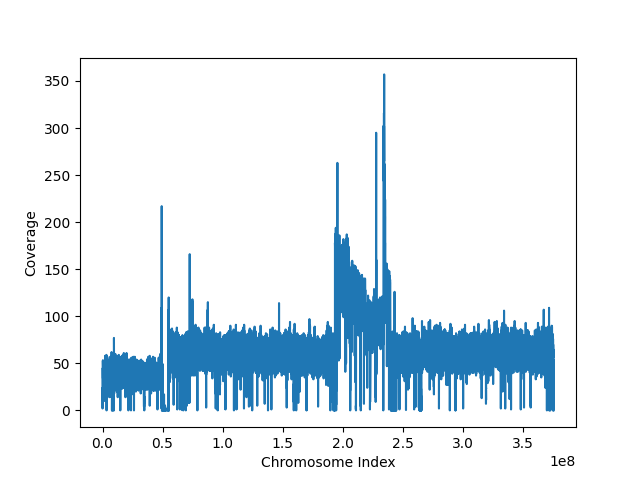

In [1]:
%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import deforest
file = "Data/James.dat"

dataThinning = 0.01 #This value controls the level of smoothing applied to the data. 0 is the raw data, 0.99(etc) is very smooth.
baseSkipping = 70 #This value controls the base-sampling rate. Higher values makes the later code run quicker, but uses less information
s = deforest.DataStruct(file,dataThinning,baseSkipping) #We have provided an inbuilt data-parser for you, because we're nice.

plt.figure(1)
plt.clf() #comment this out if you do want to layer multiple plots
plt.plot(s.Index,s.Coverage)
plt.ylabel("Coverage")
plt.xlabel("Chromosome Index")
plt.show(1)

<font color=blue>**What problems can you think we might have to overcome, in order to get this data into a form useable for machine learning?**</font>



## The Deforester

To overcome some of these problems, we have developed the *deforester*, a Bayesian inference algorithm which:
1. Determines the overall per-homolog coverage rate
2. Finds the most likely positions for 'transitions'
3. Encodes those transitions into a feature vector of variable length

The key thing which makes *deforester* work is the knowledge that 'a transition' (i.e. a duplication or deletion event) should (assuming no subclonality) result in a coverage variation which is an **integer multiple of the per-homolog coverage rate**; we then draw analogies between the resonant frequencies ('harmonics') observed in musical instruments to create a powerful statistical machinery.

The code takes three main parameters:
1. The assumed statistical distribution of the model
2. The maximum harmonic considered (this is purely a computational limit; the code runs quicker with this value smaller, but is more accurate with it larger!)
3. The *smallest permitted jump*. This prevents the code from spuriously identifying small variations: we know (for example) that the affected regions must be larger than the read length to be detected via this method (else the alignment tool would catch it)

<font color=red>**Explore the features of the provided probability distribution, and try coming up with your own**</font>

<font color=red>*Your probability distribution function should:*
1. *Be a function of the average coverage value (nu) and the measured coverage value of a given base (k)*
2. *Be negative everywhere (probabilities are less than 1, and this is a log-probability)*
3. *Not necessarily sum to 1 (the code self-normalises)*
4. *Not do anything weird like got to negative infinity*
5. *Be as weird as you like, the purpose of this is to demonstrate how varying the distribution function affects the output!*
</font>

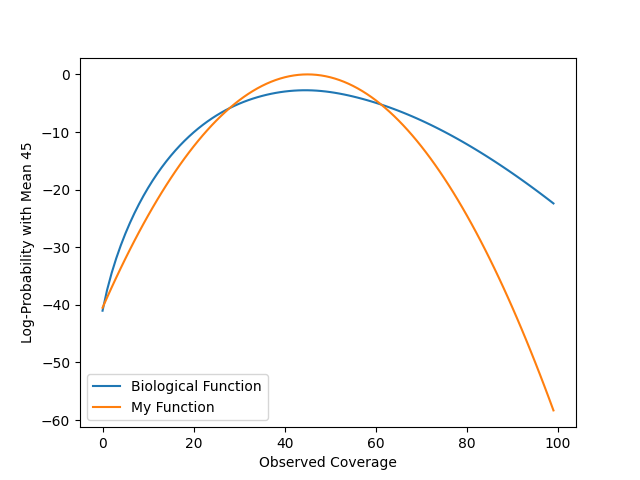

In [2]:
def jackLogProbability(k,nu):
	#This is a (somewhat) biologically motivated distribution function, which assumes that the distribution is Poisson 
	#distributed around the norm, but with some statistical noise distributed according to the Gamma distribution; which 
	#in turn means the distribution is a Negative Binomial distribution. 
	#Then on *top* of that, I add a secondary noise term which is just a big gaussian 
	#background noise centred on nu - representing a general background uncertainty in everything
	
	fractionOfDataWhichIsReal = 0.99
	dataNoise = 3
	backgroundNoise = 5
	return deforest.dualBinomial(k,nu,fractionOfDataWhichIsReal,dataNoise,backgroundNoise)

def myLogProbability(k,nu):
	sigma = 5 
	return -0.5 * ((k-nu)/sigma)**2  #this is just a boring Gaussian that I put down. You make up your own function. Get weird.

nu = 45
k = np.arange(0,100)

plt.figure(2)
plt.clf()
plt.plot(k,jackLogProbability(k,nu),label="Biological Function")
plt.plot(k,myLogProbability(k,nu),label="My Function")
plt.xlabel("Observed Coverage")
plt.legend()
plt.ylabel(f"Log-Probability with Mean {nu}")
plt.show()

## Running Deforester

The deforester algorithm uses a network-navigation based approach to ensure that the predicted harmonics are the globally most-likely set, subject to the following constraints:
* Each base in the sequence is a 'layer' in the network, which the q^th node being being associated with the q^th harmonic
* If the final minimum-distance path passes through the q^th node in the i^th layer, then the i^th base is said to have a harmonic of q 
* Assigning a base with observed coverage `k` to the `q`th harmonic incurs a penalty equal to `myProbabilityFunction(k,q*nu)`, where `nu` is an inferred fundamental frequency
* `nu` is determined by doing a rapid parameter search with resolution `SearchResolution`
* A harmonic transition cannot occur within a distance `minimumJump` from another harmonic transition
* The harmonic cannot exceed `maxHarmonic`
* A penalty of `LogJumpPrior` is applied every time a harmonic transition is applied
* A penalty of `LogDiploidPrior` is applied to every base which does not have a harmonic of 2<a name="cite_ref-2"></a>[<sup>[1]</sup>](#cite_note-2)



<a name="cite_note-2"></a>1. [^](#cite_ref-2) Because we are only looking at a subset of the Devil Genome which is badly affected by cancer, we have actually reduced this requirement for this workshop. We only apply the penalty to harmonics which are not 2, 3 or 4

In [3]:
file = "Data/Diane.dat"

preSmoothing = 0
dataSkip = 5000 #if you are running on the web hosted version (it's very slow!)
# dataSkip = 500 #if you are running locally
maxHarmonic = 10
minimumJump = 1e6


s = deforest.DataStruct(file,preSmoothing,dataSkip)
N = deforest.Network(maxHarmonic,minimumJump)
N.LogJumpPrior = -1e2 #Set this to zero to permit more jumps, set to a large negative value (< -1000) to remove jumps that the code is less certain about
N.LogDiploidPrior = -0.1 #Set this to zero to disable the Diploid Prior (for maximum impact, also increase maxHarmonic to see what happens!)
N.SearchResolution = 50 # Turn this value down to make it faster, but too low and your results become nonsense as nu cannot accurately be determined
r = N.Navigate(s,myLogProbability)

100


Navigation complete. 150603 nodes navigated in 7.769699811935425 seconds.
Maximum Score was -1958810.972532709


100


[]

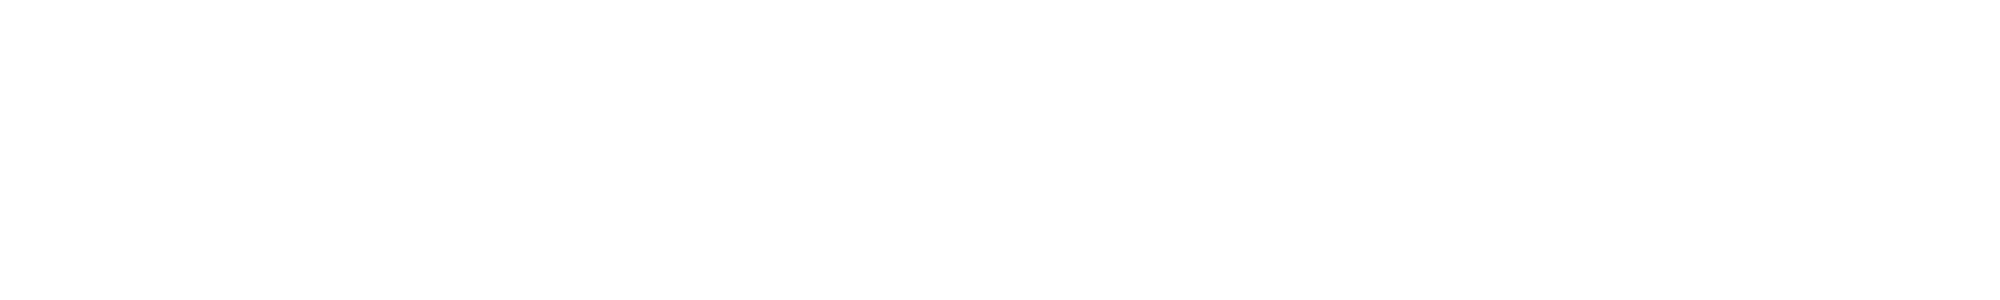

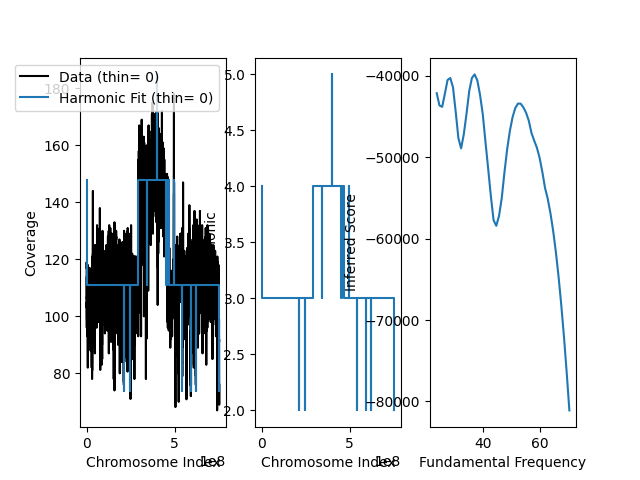

In [4]:
plt.figure(3,figsize=(20,3))

fig,axs = plt.subplots(1,3)
sPlot = deforest.DataStruct(file,0.999,dataSkip) #load a smoothed version for plotting!
axs[0].plot(sPlot.Index,sPlot.Coverage,'k',label="Data (thin= " + str(preSmoothing) + ")")
[xx,yy] = r.GetPlottingPath(s) 
axs[0].plot(xx,yy,label="Harmonic Fit (thin= " + str(preSmoothing) + ")")
axs[0].legend()
axs[0].set_xlabel("Chromosome Index")
axs[0].set_ylabel("Coverage")
axs[1].plot(xx,yy/r.Nu)
axs[1].set_xlabel("Chromosome Index")
axs[1].set_ylabel("Harmonic")
axs[2].plot(N.nus,N.scores)
axs[2].set_xlabel("Fundamental Frequency")
axs[2].set_ylabel("Inferred Score")
# for res in [10,100,1000]:
#     z = r.Encode(s,N.JumpSize,'sum',res)
#     axs[1][1].plot(np.linspace(0,1,len(z)),z,label="Resolution " + str(res))
# axs[1][1].legend()
# axs[1][0].set_xlabel("Fundamental Frequency")
# axs[1][0].set_ylabel("Log Likelihood")
# axs[1][1].set_xlabel("Fraction Along Chromosome")
# axs[1][1].set_ylabel("Encoding Value")
plt.plot()